In [63]:
import particles 
import particles.state_space_models as ssm
import particles.distributions as dists
from particles import mcmc 
from particles.collectors import Moments 

from tqdm import tqdm 
from collections import OrderedDict

from scipy.special import poch, gamma, factorial, hyp2f1

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


In [64]:
class DiracMatrix(dists.ProbDist):
    """Dirac mass distribution applied element-wise to a matrix.
    
    For a matrix M, creates a distribution where each element M[i,j] 
    follows a Dirac distribution with location parameter loc[i,j].
    
    Parameters
    ----------
    loc : array_like
        Location parameter - a 2D numpy array/matrix that defines the 
        location parameters for each element's Dirac distribution
        
    Example
    -------
    >>> import numpy as np
    >>> matrix = np.array([[1, 2], [3, 4]])
    >>> dirac = DiracMatrix(loc=matrix)
    >>> sample = dirac.rvs()  # Returns a copy of the original matrix
    >>> # Computing logpdf for a matrix where only some elements match:
    >>> test = np.array([[1, 0], [3, 4]])
    >>> dirac.logpdf(test)  # Returns -inf (since element [0,1] doesn't match)
    """

    def __init__(self, loc):
        self.loc = np.asarray(loc)
        if self.loc.ndim != 2:
            raise ValueError("loc must be a 2D array/matrix")
        self.shape = self.loc.shape
        self.dim = np.prod(self.shape)  # Total number of elements

    def rvs(self, size=None):
        if size is None:
            return self.loc.copy()
        else:
            # Return a (size, nrows, ncols) array
            return np.tile(self.loc, (size, 1, 1))

    def logpdf(self, x):
        """Returns sum of element-wise logpdfs.
        
        For each element:
        - Returns 0 if x[i,j] equals loc[i,j]
        - Returns -inf if any element differs
        """
        x = np.asarray(x)
        if x.shape[-2:] != self.shape:
            raise ValueError(f"Input matrix shape {x.shape} does not match loc shape {self.shape}")
        
        # Element-wise comparison
        element_logpdfs = np.where(x == self.loc, 0.0, -np.inf)
        
        # Sum over matrix dimensions (but preserve batch dimension if present)
        return np.sum(element_logpdfs, axis=(-2, -1))

    def ppf(self, u):
        """Percent point function (inverse of cdf).
        
        For Dirac distribution, always returns the location matrix.
        """
        if not hasattr(u, 'shape'):
            size = 1
        else:
            size = u.shape[0]
        return self.rvs(size=size)


class CSV_IG_autovar(ssm.StateSpaceModel):
    def __init__(self,rho_2=0.5,n=5):
        self.rho_2 = rho_2 
        self.n = int(n) 

        self.r = 2
        self.n_lags = 2 
        self.k_x = self.n_lags*self.r 
           
        self.matrix_sigma = np.eye(self.r)
        self.matrix_pi = np.eye(N=self.r,M=self.k_x)
    
    def PX0(self):
        d = OrderedDict()
        d['z'] = dists.MvNormal(loc = 0,scale = (1-self.rho_2)/(self.n-2),cov = np.eye(self.n))
        d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
        d['y_t'] = dists.Cond(lambda x: dists.MvNormal(loc = np.zeros(self.r), cov = self.matrix_sigma/x['k']),dim = self.r)
        for i in range(self.n_lags):
            lag = i+1
            d[f'y_t-{lag}'] = dists.Cond(lambda x: dists.MvNormal(loc = np.zeros(self.r), cov = self.matrix_sigma/x['k']),dim = self.r)
        return dists.StructDist(d)
      
    def PX(self, t, xp):
        d = OrderedDict()
        d['z'] = dists.MvNormal(loc=xp['z']*np.sqrt(self.rho_2), scale=(1-self.rho_2)/(self.n-2), cov=np.eye(self.n))
        d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
        d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
        stack = [np.array(xp[f'y_t-{i+1}']) for i in range(self.n_lags)]
        observed_regressors = np.hstack(stack)
        observed_regressors = np.array(observed_regressors).T 
        loc = self.matrix_pi@observed_regressors.flatten()
        d['y_t'] = dists.Cond(lambda x: dists.MvNormal(loc= loc, cov = self.matrix_sigma/float(x['k'])),dim = self.r)
        for i in range(self.n_lags):
            lag = i+1
            if lag == 1 : 
                d[f'y_t-{lag}'] = DiracMatrix(loc = xp['y_t'])

            elif lag > 1 :
                d[f'y_t-{lag}'] = dists.DiracMatrix(loc = xp[f'y_t-{lag-1}'])
        return dists.StructDist(d)
    
    def PY(self, t, xp, x):
        stack = [np.array(x[f'y_t-{i+1}']) for i in range(self.n_lags)]
        observed_regressors = np.hstack(stack)
        observed_regressors = np.array(observed_regressors).T 
        loc = self.matrix_pi@observed_regressors.flatten()
        return  dists.MvNormal(loc= loc, cov = self.matrix_sigma/x['k'])

  
class CSV_IG_only_error(ssm.StateSpaceModel):
    def __init__(self,rho_2=0.5,n=5):
        self.rho_2 = rho_2
        self.n = n   
        
        self.r = 2
        self.k_x = 2
        
        self.matrix_sigma = np.eye(self.r)
    
    def PX0(self):
        d = OrderedDict()
        d['z'] = dists.MvNormal(loc = 0,scale = (1-self.rho_2)/(self.n-2),cov = np.eye(self.n))
        d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
        return dists.StructDist(d)
      
    def PX(self, t, xp):
        d = OrderedDict()
        d['z'] = dists.MvNormal(loc=xp['z']*np.sqrt(self.rho_2), scale=(1-self.rho_2)/(self.n-2), cov=np.eye(self.n))
        d['k'] = dists.Cond(lambda x: dists.Dirac(loc=float(np.dot(x['z'],x['z'].T))))
        return dists.StructDist(d)
    
    def PY(self, t, xp, x):
        return dists.MvNormal(loc=np.zeros(self.r), cov=(1/x['k'])*self.matrix_sigma)
    


/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

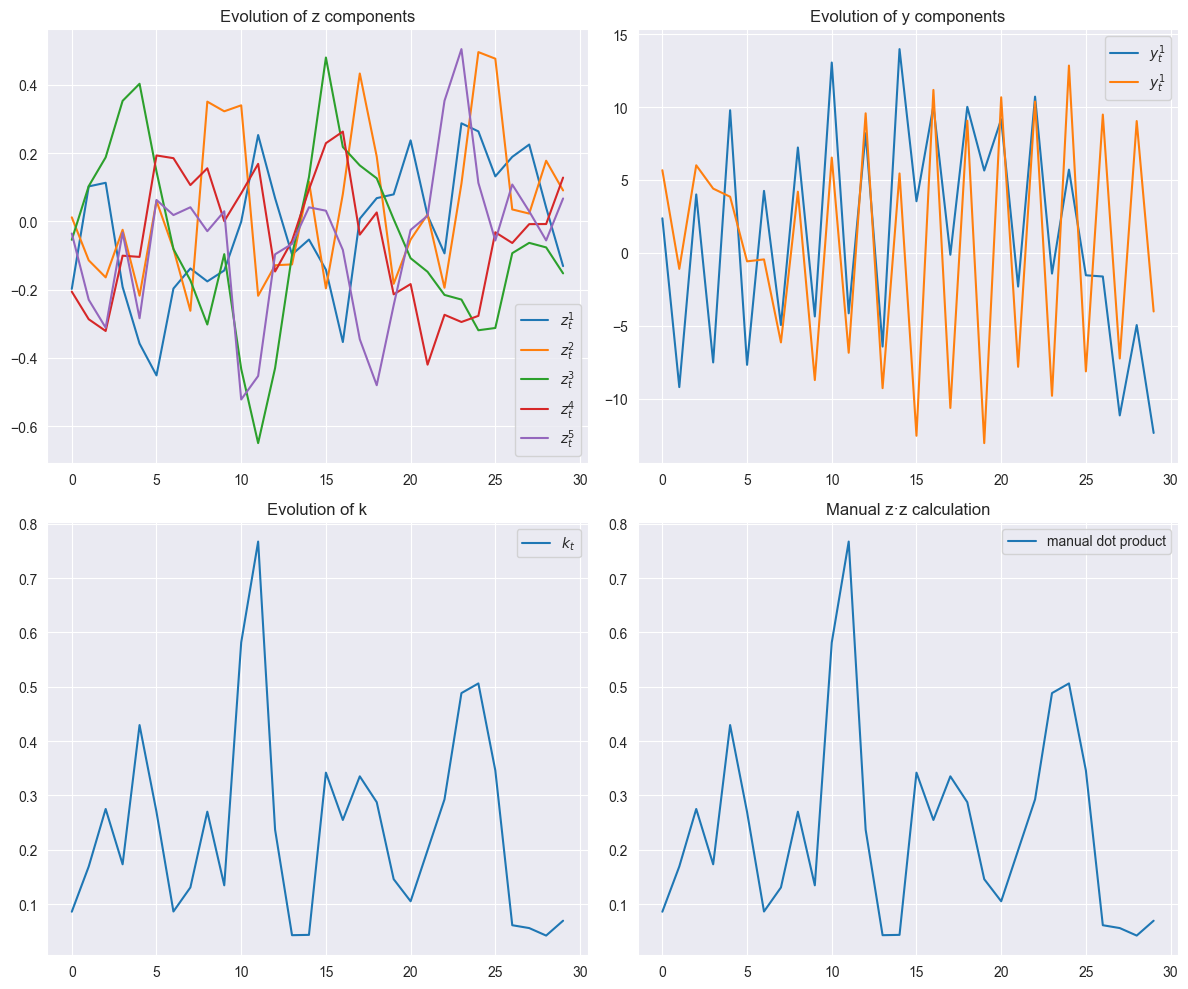

In [65]:
csv_ig = CSV_IG_autovar()
x, y = csv_ig.simulate(30)

plt.figure(figsize=(12, 10))

# First subplot for z components
plt.subplot(2, 2, 1)
for i in range(5):
    plt.plot([xt['z'][0][i] for xt in x], label=f'$z_t^{i+1}$')
plt.title('Evolution of z components')
plt.legend()

# Second subplot for y components
plt.subplot(2, 2, 2)
for i in range(y[0].shape[0]):
    plt.plot([yt[i] for yt in y], label=f'$y_t^{i+1}$')
plt.title('Evolution of y components')
plt.legend()

# Third subplot for k
plt.subplot(2, 2, 3)
plt.plot([xt['k'] for xt in x], label=r'$k_t$')
plt.title('Evolution of k')
plt.legend()

# Fourth subplot for manual dot product calculation
plt.subplot(2, 2, 4)
manual_dots = [float(np.dot(np.array(xt['z']),np.array(xt['z']).T)) for xt in x]
plt.plot(manual_dots, label='manual dot product')
plt.title('Manual z·z calculation')
plt.legend()

plt.tight_layout()
plt.show()



/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc=float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/601512791.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single elemen

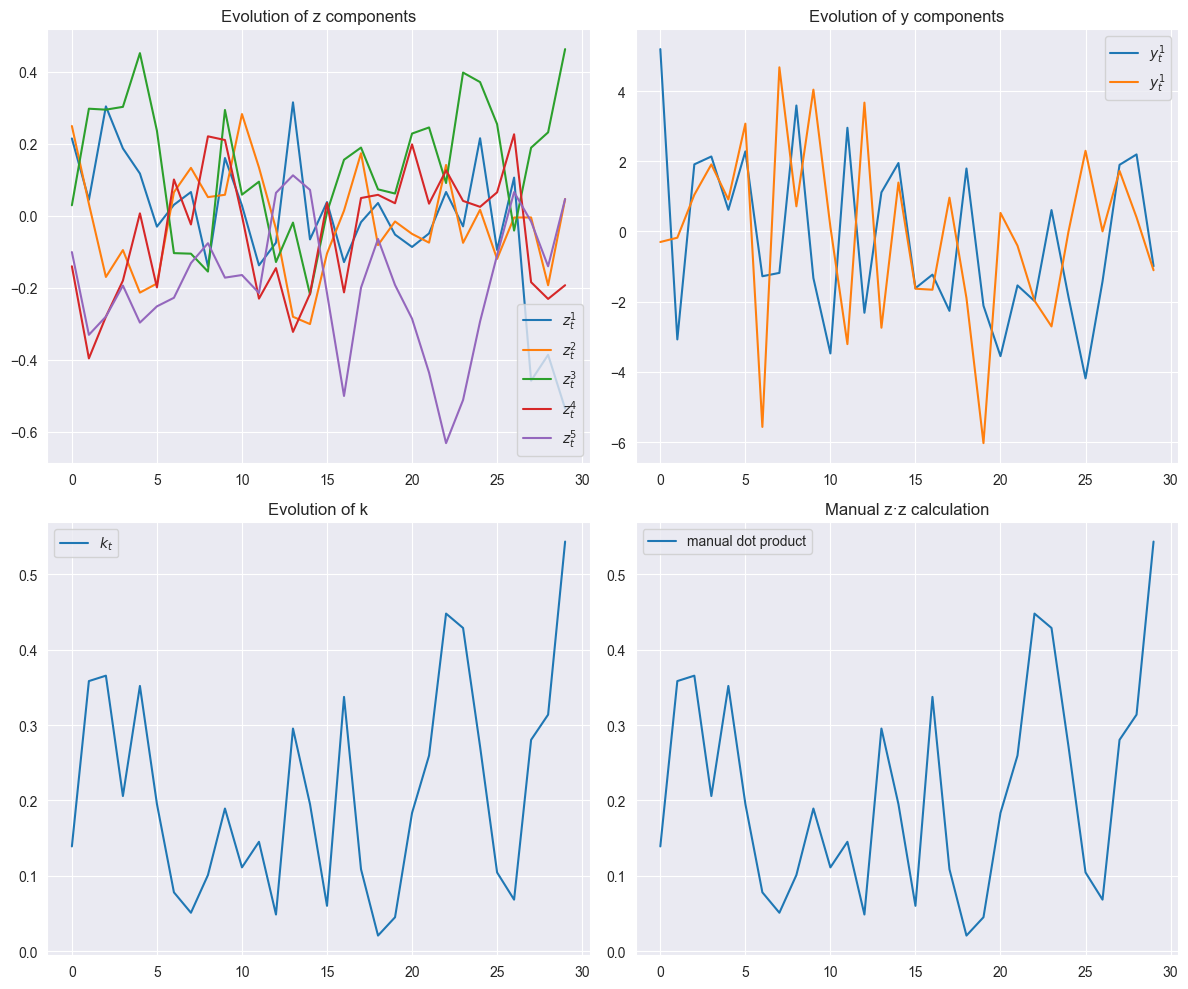

In [66]:
csv_ig = CSV_IG_only_error()
x, y = csv_ig.simulate(30)

plt.figure(figsize=(12, 10))

# First subplot for z components
plt.subplot(2, 2, 1)
for i in range(5):
    plt.plot([xt['z'][0][i] for xt in x], label=f'$z_t^{i+1}$')
plt.title('Evolution of z components')
plt.legend()

# Second subplot for y components
plt.subplot(2, 2, 2)
for i in range(y[0].shape[0]):
    plt.plot([yt[i] for yt in y], label=f'$y_t^{i+1}$')
plt.title('Evolution of y components')
plt.legend()

# Third subplot for k
plt.subplot(2, 2, 3)
plt.plot([xt['k'] for xt in x], label=r'$k_t$')
plt.title('Evolution of k')
plt.legend()

# Fourth subplot for manual dot product calculation
plt.subplot(2, 2, 4)
manual_dots = [float(np.dot(np.array(xt['z']),np.array(xt['z']).T)) for xt in x]
plt.plot(manual_dots, label='manual dot product')
plt.title('Manual z·z calculation')
plt.legend()

plt.tight_layout()
plt.show()



In [67]:
def get_terms(x, y, model):
    """
    Calcul des termes ε_t, S_t, Ṽ_t^{-1}, Z_t, et δ_t sur l'ensemble de la période.
    """
    terms_history = {}

    # Params
    matrix_pi = model.matrix_pi
    matrix_sigma = model.matrix_sigma
    rho_2 = model.rho_2
    n_lags = model.n_lags
    n_steps = len(y)

    # Calcul de V1
    V_1 = (1 - rho_2)**-1

    # Calcul de ε1
    stack_1 = [np.array(x[0][f'y_t-{i+1}']) for i in range(n_lags)]
    x_1 = np.hstack(stack_1).T
    y_1 = y[0].T
    e_1 = y_1 - np.dot(matrix_pi, x_1)
    epsilon_1_squared = np.dot(e_1.T, np.linalg.solve(matrix_sigma, e_1))

    # Calcul de Ṽ2⁻¹
    V2_tilde_inv = V_1**-1 + epsilon_1_squared
    terms_history[2] = {'Vt_tilde_inv': V2_tilde_inv}

    for t in range(3, n_steps + 1):
        # Calcul de e_{t-1}
        stack_t_minus_1 = [np.array(x[t - 2][f'y_t-{i+1}']) for i in range(n_lags)]
        x_t_minus_1 = np.hstack(stack_t_minus_1).T
        y_t_minus_1 =y[t - 2].T
        e_t_minus_1 = y_t_minus_1 - np.dot(matrix_pi, x_t_minus_1)

        # Calcul de ε_{t-1}²
        epsilon_t_minus_1_squared = np.dot(e_t_minus_1.T, np.linalg.solve(matrix_sigma, e_t_minus_1))

        # Calcul de S_t
        S_t = (epsilon_t_minus_1_squared + 1 + rho_2)**-1

        # Calcul de Ṽ_t^{-1}
        Vt_tilde_inv = epsilon_t_minus_1_squared + 1

        ###############

        # Calcul de e_{t}
        stack_t = [np.array(x[t - 1][f'y_t-{i+1}']) for i in range(n_lags)]
        x_t = np.hstack(stack_t).T
        y_t = y[t - 1].T
        e_t = y_t - np.dot(matrix_pi, x_t)

        # Calcul de ε_{t}²
        epsilon_t_squared = np.dot(e_t.T, np.linalg.solve(matrix_sigma, e_t))

        # Calcul de Z_t
        Z_t = (epsilon_t_squared + 1)**-1 * S_t * rho_2

        # Calcul de δ_t
        delta_t = ((1 - rho_2 * S_t)**-1) * S_t * rho_2 * (terms_history[t - 1]['Vt_tilde_inv'] + rho_2)**-1

        terms_history[t] = {
            'S_t': S_t,
            'Vt_tilde_inv': Vt_tilde_inv,
            'Z_t': Z_t,
            'delta_t': delta_t,
            'epsilon_t_squared': epsilon_t_squared,
        }

    return terms_history

In [68]:
def log_likelihood_Y1(x, y, model):
    """
    Calcul de la log-vraisemblance L(Y1).
    """
    # Params
    matrix_pi = model.matrix_pi
    matrix_sigma = model.matrix_sigma
    n = model.n
    rho_2 = model.rho_2
    n_lags = model.n_lags
    r = y[0].shape[1]

    # Calcul de V1
    V_1 = (1 - rho_2)**-1

    # Calcul de e1 = Y1 - Π * X1
    stack = [np.array(x[0][f'y_t-{i+1}']) for i in range(n_lags)]
    x_1 = np.hstack(stack).T
    y_1 = y[0].T
    e_1 = y_1 - np.dot(matrix_pi, x_1)

    # Calcul de e1' Σ^(-1) e1
    epsilon_1_squared = np.dot(e_1.T, np.linalg.solve(matrix_sigma, e_1))

    # Calcul de la log-vraisemblance
    log_likelihood = (
        -0.5 * r * np.log(2 * np.pi)
        - 0.5 * np.log(np.linalg.det(matrix_sigma))
        + 0.5 * r * np.log(2)
        + np.log(gamma((n + r) / 2)) - np.log(gamma(n / 2))
        - ((n + r) / 2) * np.log(np.abs(V_1**-1 + epsilon_1_squared))
        - 0.5 * n * V_1
    )

    return log_likelihood.flatten()

In [69]:
def log_likelihood_Y2_given_Y1(x, y, model):
    """
    Calcul de la log-vraisemblance L(Y2 | Y1).
    """
    # Params
    matrix_pi = model.matrix_pi
    matrix_sigma = model.matrix_sigma
    n = model.n
    rho_2 = model.rho_2
    n_lags = model.n_lags
    r = y[0].shape[1]

    # Calcul de V1
    V_1 = (1 - rho_2)**-1

    # Calcul de ε1
    stack_1 = [np.array(x[0][f'y_t-{i+1}']) for i in range(n_lags)]
    x_1 = np.hstack(stack_1).T
    y_1 = y[0].T
    e_1 = y_1 - np.dot(matrix_pi, x_1)
    epsilon_1_squared = np.dot(e_1.T, np.linalg.solve(matrix_sigma, e_1))

    # Calcul de Ṽ2⁻¹
    V2_tilde_inv = V_1**-1 + epsilon_1_squared

    # Calcul de δ2
    delta_2 = (rho_2) * (V2_tilde_inv + rho_2)**-1

    #################

    # Calcul de ε2
    stack_2 = [np.array(x[1][f'y_t-{i+1}']) for i in range(n_lags)]
    x_2 = np.hstack(stack_2).T
    y_2 = y[1].T
    e_2 = y_2 - np.dot(matrix_pi, x_2)
    epsilon_2_squared = np.dot(e_2.T, np.linalg.solve(matrix_sigma, e_2))

    # Calcul de Z2
    Z_2 = (epsilon_2_squared + 1)**-1 * delta_2

    # Calcul de Ĉ2
    C2_hat = hyp2f1((n + r) / 2, (n + r) / 2, n / 2, Z_2)

    # Calcul final de la log-vraisemblance conditionnelle
    log_likelihood = (
        -0.5 * r * np.log(2 * np.pi)
        - 0.5 * np.log(np.linalg.det(matrix_sigma))
        + 0.5 * (n + r) * np.log(2) - 0.5 * n * np.log(2)
        + np.log(gamma((n + r) / 2)) - np.log(gamma(n / 2))
        - ((n + r) / 2) * np.log(epsilon_2_squared + 1)
        + ((n + r) / 2) * np.log(1 - delta_2)
        + np.log(C2_hat)
    )

    return log_likelihood.flatten()


In [70]:
def log_likelihood_at_t(x, y, model, terms_history, curr_t, h_max=10):
    """
    Calcul de la log-vraisemblance L(Yt | Y1:Yt-1), t >= 3.
    """
    # Params
    matrix_sigma = model.matrix_sigma
    n = model.n
    rho_2 = model.rho_2
    r = y[0].shape[1]

    # Récupération des termes nécessaires
    S_t = terms_history[curr_t]['S_t']
    delta_t = terms_history[curr_t]['delta_t']
    Z_t = terms_history[curr_t]['Z_t']
    epsilon_t_squared = terms_history[curr_t]['epsilon_t_squared']
    Vt_tilde_inv = terms_history[curr_t - 1]['Vt_tilde_inv']

    # Calcul de c
    hypergeom_term = hyp2f1((n + r) / 2, (n + r) / 2, n / 2, delta_t)
    gamma_term = gamma((n + r) / 2)
    c_t = hypergeom_term * gamma_term * (1 - rho_2 * S_t)**(-(n + r) / 2) * (2 * S_t)**((n + r) / 2)

    # Calcul de la somme complète pour t >= 3
    likelihood_sum = 0
    for ht in range(h_max + 1):
        # Calcul de C_tilde
        term1 = poch((n + r) / 2, ht) / poch(n / 2, ht)
        term2 = ((0.5 * rho_2 * (Vt_tilde_inv + rho_2)**-1) ** ht)
        term3 = 1 / factorial(ht)
        C_tilde = term1 * term2 * term3

        # Calcul de C_hat
        C_hat = hyp2f1((n + r + 2 * ht) / 2, (n + r) / 2, n / 2, Z_t)

        # Termes dépendant de ht
        gamma_ht = gamma((n + r + 2 * ht) / 2)
        St_ht = (2 * S_t)**((n + r + 2 * ht) / 2)

        # Autres termes
        epsilon_term = (epsilon_t_squared + 1)**(-(n + r) / 2)
        remains = 2**((n + r) / 2) * 2**(-n / 2) * gamma((n + r) / 2) * gamma(n / 2)**-1

        # Ajout à la somme
        likelihood_sum += C_tilde * C_hat * gamma_ht * St_ht * epsilon_term * remains


    # Finalisation de la log-vraisemblance pour t >= 3
    log_likelihood = (
        -0.5 * r * np.log(2 * np.pi)
        - 0.5 * np.log(np.linalg.det(matrix_sigma))
        - np.log(c_t)
        + np.log(likelihood_sum)
    )

    return log_likelihood.flatten()

In [71]:
def get_log_likelihood(x, y, model):
    log_likelihood = pd.Series(index=range(1, len(y) + 1), dtype=float)
    terms_history = get_terms(x, y, model)

    # Log-likelihood computation
    for curr_t in range(1, len(y) + 1):
        if curr_t == 1:
            log_likelihood[curr_t] = log_likelihood_Y1(x, y, model)
        elif curr_t == 2:
            log_likelihood[curr_t] = log_likelihood_Y2_given_Y1(x, y, model)
        else:  
            log_likelihood[curr_t] = log_likelihood_at_t(x, y, model, terms_history, curr_t)

    return log_likelihood

In [72]:
csv_ig = CSV_IG_autovar()
x, y = csv_ig.simulate(30)
log_likelihood = get_log_likelihood(x, y, csv_ig)

/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

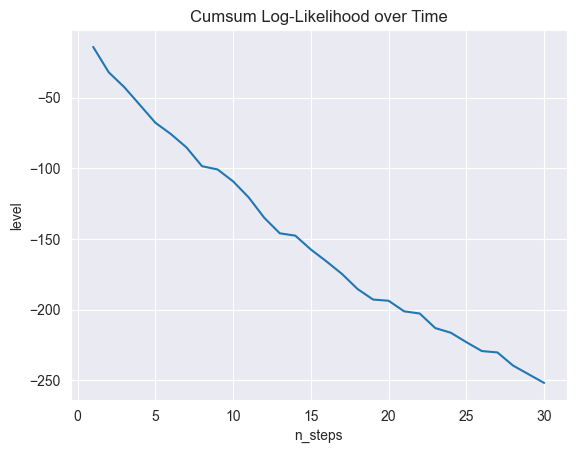

In [73]:
log_likelihood.cumsum().plot(title='Cumsum Log-Likelihood over Time', xlabel='n_steps', ylabel='level')
plt.show()

In [74]:
class Bootstrap_StructDist(particles.FeynmanKac):
    """Bootstrap Feynman-Kac formalism of a given state-space model.

    Parameters
    ----------

    ssm: `StateSpaceModel` object
        the considered state-space model
    data: list-like
        the data

    Returns
    -------
    `FeynmanKac` object
        the Feynman-Kac representation of the bootstrap filter for the
        considered state-space model
    """

    def __init__(self, ssm=None, data=None):
        self.ssm = ssm
        self.data = data
        self.du = self.ssm.PX0().dim

    @property
    def T(self):
        return 0 if self.data is None else len(self.data)

    def M0(self, N):
        x = []
        for i in range(N):
            law_x = self.ssm.PX0()
            x.append(law_x.rvs(size=1))
        x = np.array(x)
        return x

    def M(self, t, xp):
        x = []
        for xp_ in xp : 
            x.append(self.ssm.PX(t, xp_).rvs(size=1))
        x = np.array(x)
        return x

    def logG(self, t, xp, x):
        N = len(x)
        lw = []
        for i in range(N):
            x_ = x[i]
            if not xp is None : 
                xp_ = xp[i]
            else : 
                xp_ = None
            log_pdf =  self.ssm.PY(t, xp = xp_, x = x_).logpdf(self.data[t])
            lw.append(log_pdf)
        lw = np.array(lw)

  
        return lw 

    def Gamma0(self, u):
        return self.ssm.PX0().ppf(u)

    def Gamma(self, t, xp, u):
        return self.ssm.PX(t, xp).ppf(u)

    def logpt(self, t, xp, x):
        """PDF of X_t|X_{t-1}=xp"""
        return self.ssm.PX(t, xp).logpdf(x)

    def upper_bound_trans(self, t):
        return self.ssm.upper_bound_log_pt(t)

    def add_func(self, t, xp, x):
        return self.ssm.add_func(t, xp, x)

/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc=float(np.dot(x['z'],x['z'].T))))


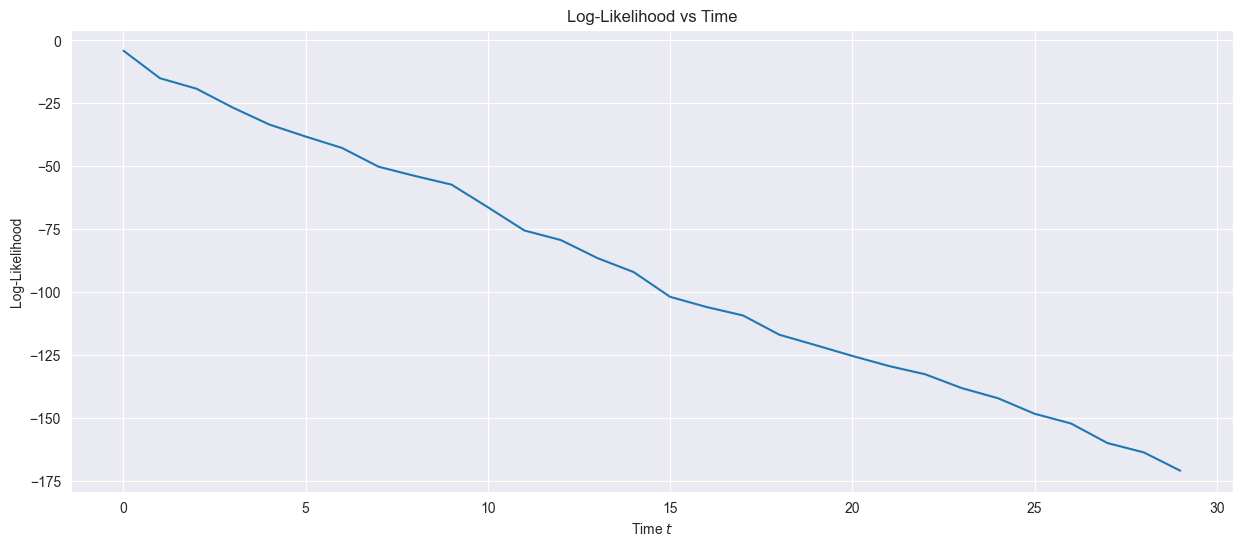

In [75]:
csv_ig = CSV_IG_only_error()
fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified')  # the algorithm
pf.run()  # actual computation

plt.figure(figsize=(15, 6))

# First subplot: Line plot (original plot)
plt.plot(range(len(pf.logLt_cumulative)), pf.logLt_cumulative, '-')
plt.xlabel('Time $t$')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Time')
plt.grid(True)



/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

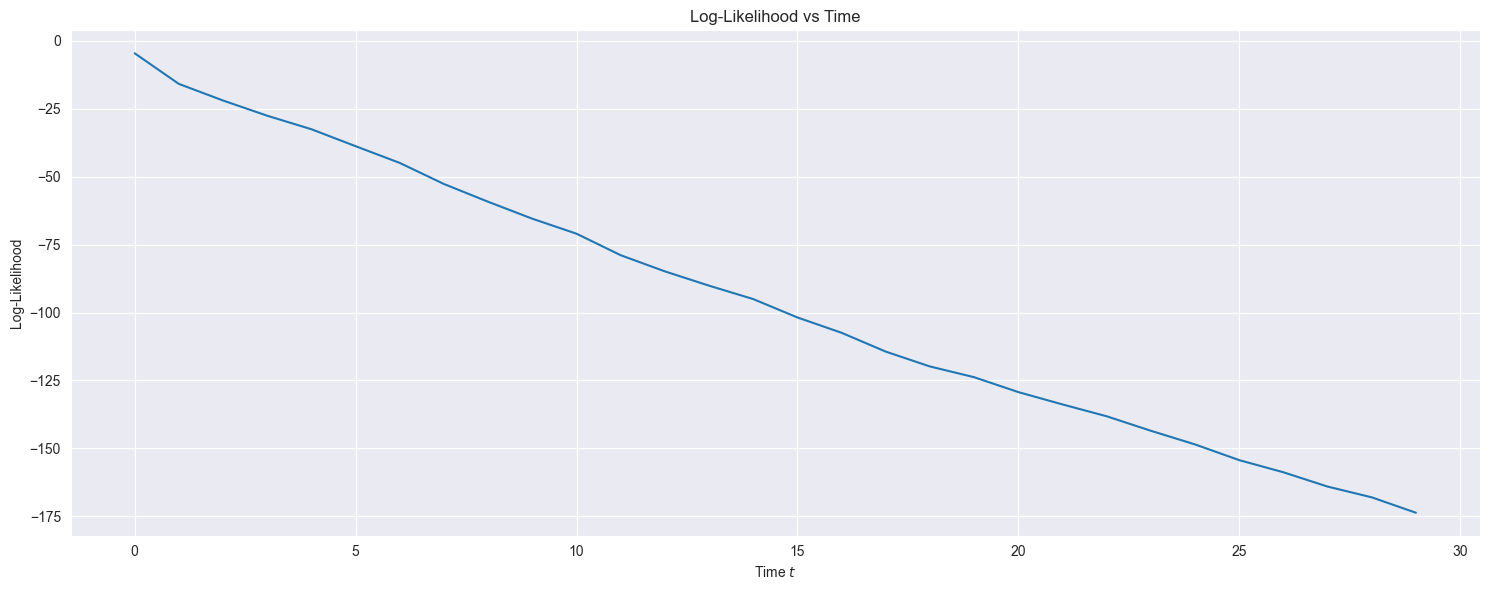

In [76]:
csv_ig = CSV_IG_autovar()
fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified')  # the algorithm
pf.run()  # actual computation

plt.figure(figsize=(15, 6))

plt.plot(range(len(pf.logLt_cumulative)), pf.logLt_cumulative, '-')
plt.xlabel('Time $t$')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Time')
plt.grid(True)


plt.tight_layout()
plt.show()

In [77]:
import json

# Nombre d'itérations de simulation
N_iter = 1000

# Initialisation dictionnaires pour stocker les résultats
analytics_logLt = {}
simulation_logLt = {}

# Création de l'instance du modèle CSV_IG
csv_ig = CSV_IG_autovar()

# Boucle de simulation sur N_iter
for i in tqdm(range(N_iter), total=N_iter, desc='Simulating data'):
    # Simulation des données
    x, y = csv_ig.simulate(100)

    # Application du filtre Bootstrap SMC
    fk_model = Bootstrap_StructDist(ssm=csv_ig, data=y)
    pf = particles.SMC(fk=fk_model, N=50, resampling='stratified')
    pf.run()

    # Log-vraisemblance cumulée via la simulation SMC
    logLt_simulation = float(pf.logLt)  # Convertir en float Python

    # Calcul analytique de la log-vraisemblance
    log_likelihood = get_log_likelihood(x, y, csv_ig)
    logLt_analytic = float(log_likelihood.cumsum().iloc[-1])

    # Stocker les deux résultats dans le dictionnaire
    analytics_logLt[i] = logLt_analytic
    simulation_logLt[i] = logLt_simulation

# Sauvegarder les résultats dans deux fichiers JSON séparés
with open('analytics_logLt_autovar.json', 'w') as f:
    json.dump(analytics_logLt, f, indent=4)

with open('simulation_logLt_autovar.json', 'w') as f:
    json.dump(simulation_logLt, f, indent=4)

print("Results stored")


Simulating data:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, an

Results stored


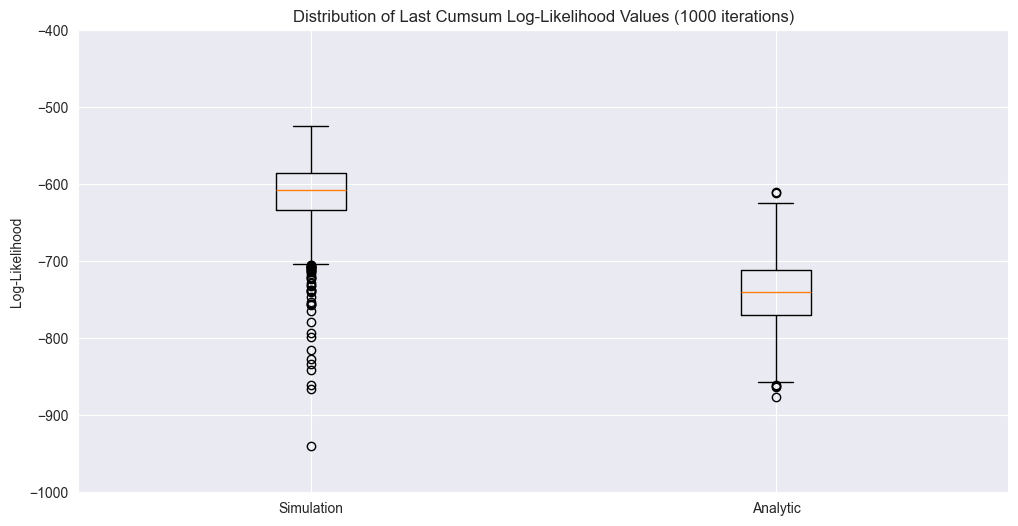

Mean log-likelihood (Simulation): -627.81
Std log-likelihood (Simulation): 176.64
Median log-likelihood (Simulation): -607.41
5th percentile (Simulation): -705.77
95th percentile (Simulation): -559.08

Mean log-likelihood (Analytic): -740.94
Std log-likelihood (Analytic): 44.07
Median log-likelihood (Analytic): -740.04
5th percentile (Analytic): -814.31
95th percentile (Analytic): -667.54


In [78]:
# Load the JSON file
with open('analytics_logLt_autovar.json', 'r') as f:
    analytics_logLt_autovar = json.load(f)

with open('simulation_logLt_autovar.json', 'r') as f:
    simulation_logLt_autovar = json.load(f)

analytics_values = list(analytics_logLt_autovar.values())
simulation_values = list(simulation_logLt_autovar.values())

# Create box plots for both distributions
plt.figure(figsize=(12, 6))
plt.boxplot([simulation_values, analytics_values], labels=['Simulation', 'Analytic'])
plt.ylim(-1000, -400)
plt.title('Distribution of Last Cumsum Log-Likelihood Values (1000 iterations)')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()

# Print descriptive statistics
print(f"Mean log-likelihood (Simulation): {np.mean(simulation_values):.2f}")
print(f"Std log-likelihood (Simulation): {np.std(simulation_values):.2f}")
print(f"Median log-likelihood (Simulation): {np.median(simulation_values):.2f}")
print(f"5th percentile (Simulation): {np.percentile(simulation_values, 5):.2f}")
print(f"95th percentile (Simulation): {np.percentile(simulation_values, 95):.2f}")

print(f"\nMean log-likelihood (Analytic): {np.mean(analytics_values):.2f}")
print(f"Std log-likelihood (Analytic): {np.std(analytics_values):.2f}")
print(f"Median log-likelihood (Analytic): {np.median(analytics_values):.2f}")
print(f"5th percentile (Analytic): {np.percentile(analytics_values, 5):.2f}")
print(f"95th percentile (Analytic): {np.percentile(analytics_values, 95):.2f}")


/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc=float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/1701233049.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

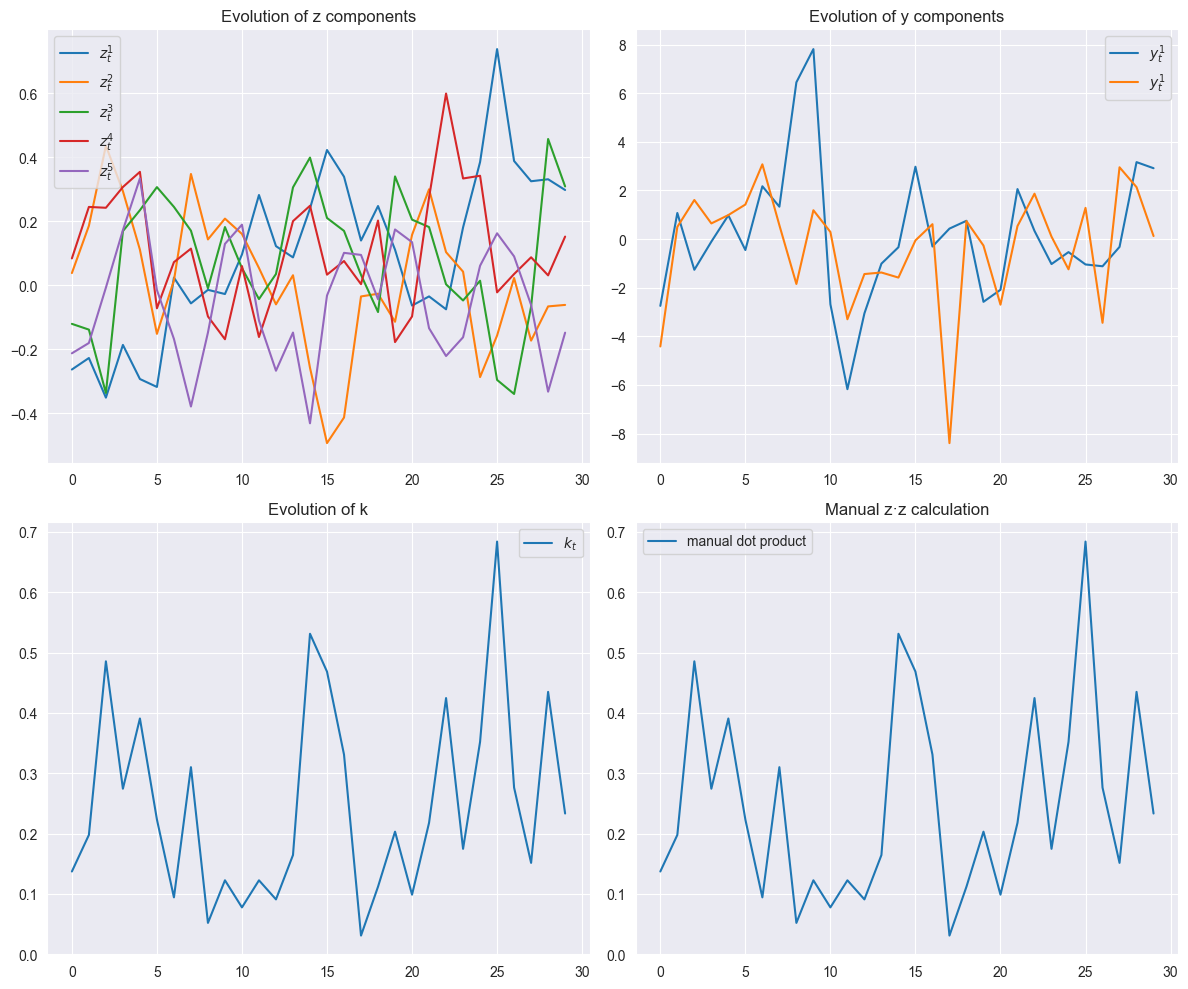

In [79]:
csv_ig = CSV_IG_only_error()
x, y = csv_ig.simulate(30)

plt.figure(figsize=(12, 10))

# First subplot for z components
plt.subplot(2, 2, 1)
for i in range(5):
    plt.plot([xt['z'][0][i] for xt in x], label=f'$z_t^{i+1}$')
plt.title('Evolution of z components')
plt.legend()

# Second subplot for y components
plt.subplot(2, 2, 2)
for i in range(y[0].shape[0]):
    plt.plot([yt[i] for yt in y], label=f'$y_t^{i+1}$')
plt.title('Evolution of y components')
plt.legend()

# Third subplot for k
plt.subplot(2, 2, 3)
plt.plot([xt['k'] for xt in x], label=r'$k_t$')
plt.title('Evolution of k')
plt.legend()

# Fourth subplot for manual dot product calculation
plt.subplot(2, 2, 4)
manual_dots = [float(np.dot(np.array(xt['z']),np.array(xt['z']).T)) for xt in x]
plt.plot(manual_dots, label='manual dot product')
plt.title('Manual z·z calculation')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
class Bootstrap_StructDist(particles.FeynmanKac):
    """Bootstrap Feynman-Kac formalism of a given state-space model.

    Parameters
    ----------

    ssm: `StateSpaceModel` object
        the considered state-space model
    data: list-like
        the data

    Returns
    -------
    `FeynmanKac` object
        the Feynman-Kac representation of the bootstrap filter for the
        considered state-space model
    """

    def __init__(self, ssm=None, data=None):
        self.ssm = ssm
        self.data = data
        self.du = self.ssm.PX0().dim

    @property
    def T(self):
        return 0 if self.data is None else len(self.data)

    def M0(self, N):
        x = []
        for i in range(N):
            law_x = self.ssm.PX0()
            x.append(law_x.rvs(size=1))
        x = np.array(x)
        return x

    def M(self, t, xp):
        x = []
        for xp_ in xp : 
            x.append(self.ssm.PX(t, xp_).rvs(size=1))
        x = np.array(x)
        return x

    def logG(self, t, xp, x):
        N = len(x)
        lw = []
        for i in range(N):
            x_ = x[i]
            if not xp is None : 
                xp_ = xp[i]
            else : 
                xp_ = None
            log_pdf =  self.ssm.PY(t, xp = xp_, x = x_).logpdf(self.data[t])
            lw.append(log_pdf)
        lw = np.array(lw)

  
        return lw 

    def Gamma0(self, u):
        return self.ssm.PX0().ppf(u)

    def Gamma(self, t, xp, u):
        return self.ssm.PX(t, xp).ppf(u)

    def logpt(self, t, xp, x):
        """PDF of X_t|X_{t-1}=xp"""
        return self.ssm.PX(t, xp).logpdf(x)

    def upper_bound_trans(self, t):
        return self.ssm.upper_bound_log_pt(t)

    def add_func(self, t, xp, x):
        return self.ssm.add_func(t, xp, x)

/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc=float(np.dot(x['z'],x['z'].T))))


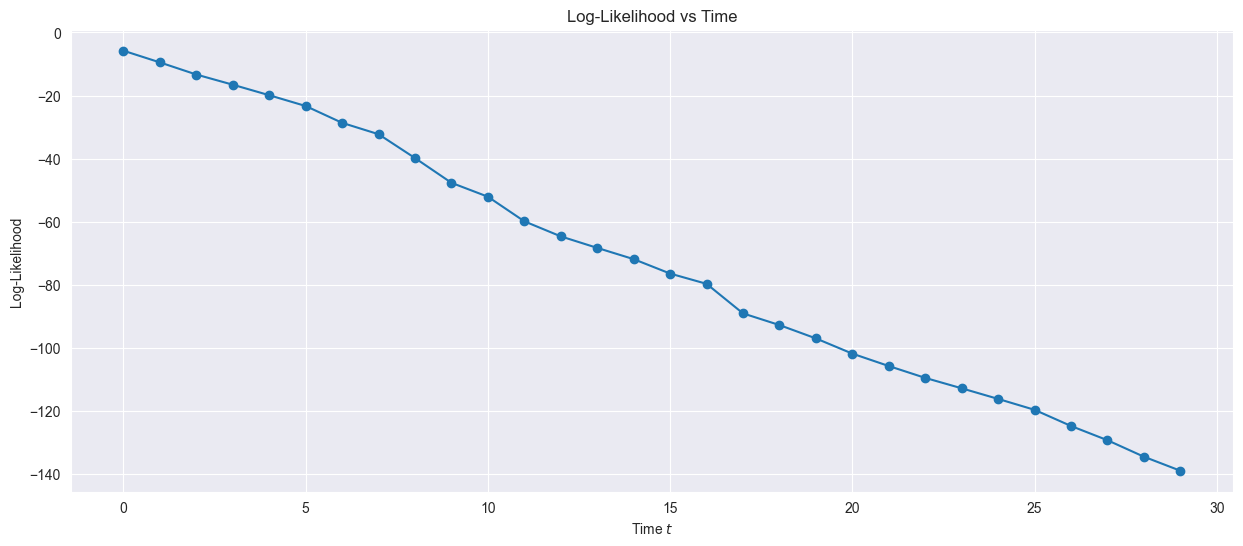

In [81]:
csv_ig = CSV_IG_only_error()
fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified')  # the algorithm
pf.run()  # actual computation

plt.figure(figsize=(15, 6))

# First subplot: Line plot (original plot)
plt.plot(range(len(pf.logLt_cumulative)), pf.logLt_cumulative, marker='o')
plt.xlabel('Time $t$')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Time')
plt.grid(True)

/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

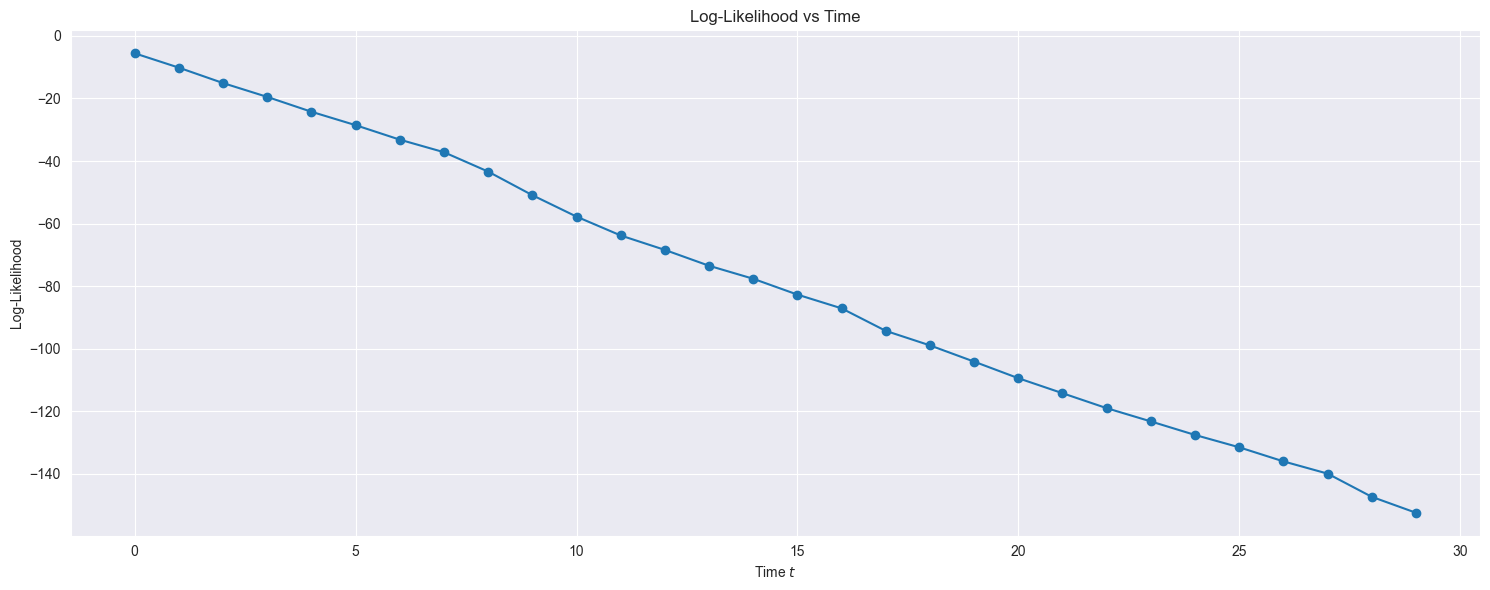

In [82]:

csv_ig = CSV_IG_autovar()
fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
pf = particles.SMC(fk=fk_model, N=100, resampling='stratified')  # the algorithm
pf.run()  # actual computation

plt.figure(figsize=(15, 6))

plt.plot(range(len(pf.logLt_cumulative)), pf.logLt_cumulative, marker='o')
plt.xlabel('Time $t$')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Time')
plt.grid(True)


plt.tight_layout()
plt.show()

In [83]:
''' CSV autovar model ''' 
import json
N_iter = 1000
era_to_logLt = {}
csv_ig = CSV_IG_autovar()
for i in tqdm(range(N_iter),total=N_iter,desc='Simulating data'):
    x,y = csv_ig.simulate(100)
    fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
    pf = particles.SMC(fk=fk_model, N=50, resampling='stratified')  # the algorithm
    pf.run()  # actual computation
    era_to_logLt[i] = float(pf.logLt)  # Convert numpy float to Python float for JSON serialization
    with open('era_to_logLt_autovar.json', 'w') as f:
        json.dump(era_to_logLt, f)










Simulating data:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, an

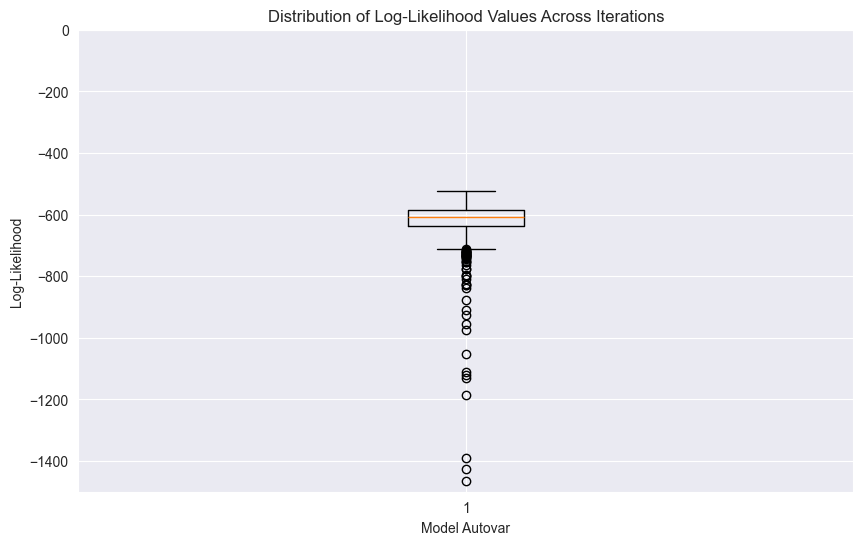

Mean log-likelihood: -634.54
Std log-likelihood: 289.24
Median log-likelihood: -607.67
5th percentile: -718.54
95th percentile: -557.34


In [84]:
with open('era_to_logLt_autovar.json', 'r') as f:
    era_to_logLt = json.load(f)

logLt_values = list(era_to_logLt.values())

plt.figure(figsize=(10, 6))
plt.boxplot(logLt_values)
plt.title('Distribution of Log-Likelihood Values Across Iterations')
plt.ylabel('Log-Likelihood')
plt.xlabel('Model Autovar')
plt.grid(True)
plt.ylim(-1500, 0)
plt.show()


print(f"Mean log-likelihood: {np.mean(logLt_values):.2f}")
print(f"Std log-likelihood: {np.std(logLt_values):.2f}")
print(f"Median log-likelihood: {np.median(logLt_values):.2f}")
print(f"5th percentile: {np.percentile(logLt_values, 5):.2f}")
print(f"95th percentile: {np.percentile(logLt_values, 95):.2f}")

In [85]:
''' CSV only error model ''' 
import json
N_iter = 1000
era_to_logLt = {}
csv_ig = CSV_IG_only_error()
for i in tqdm(range(N_iter),total=N_iter,desc='Simulating data'):
    x,y = csv_ig.simulate(100)
    fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
    pf = particles.SMC(fk=fk_model, N=50, resampling='stratified')  # the algorithm
    pf.run()  # actual computation
    era_to_logLt[i] = float(pf.logLt)  # Convert numpy float to Python float for JSON serialization
    with open('era_to_logLt_only_error.json', 'w') as f:
        json.dump(era_to_logLt, f)



Simulating data:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc = float(np.dot(x['z'],x['z'].T))))
/var/folders/bv/0p7264dn6b94k6wr2_l1_gqh0000gn/T/ipykernel_90911/3020191732.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d['k'] = dists.Cond(lambda x: dists.Dirac(loc=float(np.dot(x['z'],x['z'].T))))
Simulating data: 100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


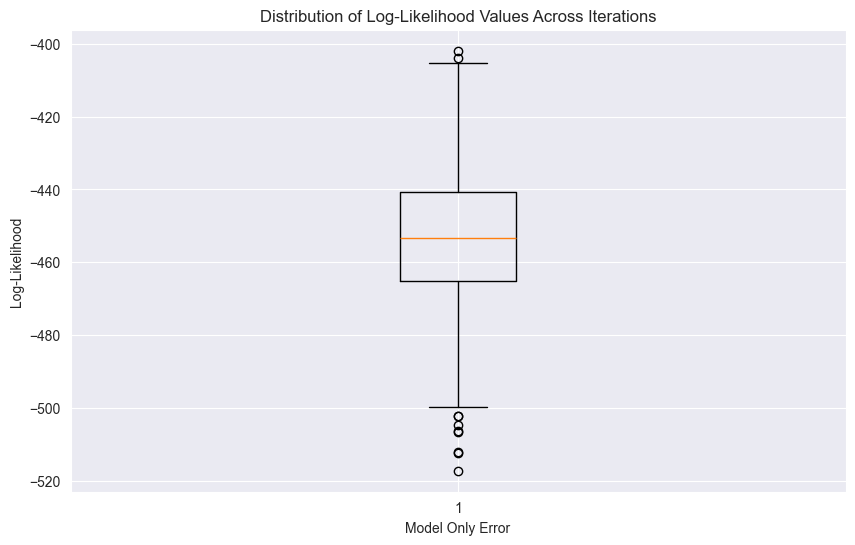

Mean log-likelihood: -453.59
Std log-likelihood: 18.07
Median log-likelihood: -453.26
5th percentile: -483.85
95th percentile: -424.79


In [86]:
with open('era_to_logLt_only_error.json', 'r') as f:
    era_to_logLt = json.load(f)

logLt_values = list(era_to_logLt.values())

plt.figure(figsize=(10, 6))
plt.boxplot(logLt_values)
plt.title('Distribution of Log-Likelihood Values Across Iterations')
plt.ylabel('Log-Likelihood')
plt.xlabel('Model Only Error')
plt.grid(True)
plt.show()


print(f"Mean log-likelihood: {np.mean(logLt_values):.2f}")
print(f"Std log-likelihood: {np.std(logLt_values):.2f}")
print(f"Median log-likelihood: {np.median(logLt_values):.2f}")
print(f"5th percentile: {np.percentile(logLt_values, 5):.2f}")
print(f"95th percentile: {np.percentile(logLt_values, 95):.2f}")

In [ ]:
import json 
args = [(rho_2,n) for rho_2 in [0.01,0.5,0.9] for n in [3,10,100]]
variation_to_logLt = {str(arg) : [] for arg in args}
N_iter = 250


for arg in tqdm(args,total=len(args),desc='Simulating data'):
    for i in range(N_iter):
        csv_ig = CSV_IG_autovar(rho_2=arg[0],n=arg[1])
        x,y = csv_ig.simulate(100)
        fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
        pf = particles.SMC(fk=fk_model, N=50, resampling='stratified')  # the algorithm
        pf.run()  # actual computation
        variation_to_logLt[str(arg)].append(float(pf.logLt))
        with open('variation_to_logLt_autovar.json', 'w') as f:
            json.dump(variation_to_logLt, f)

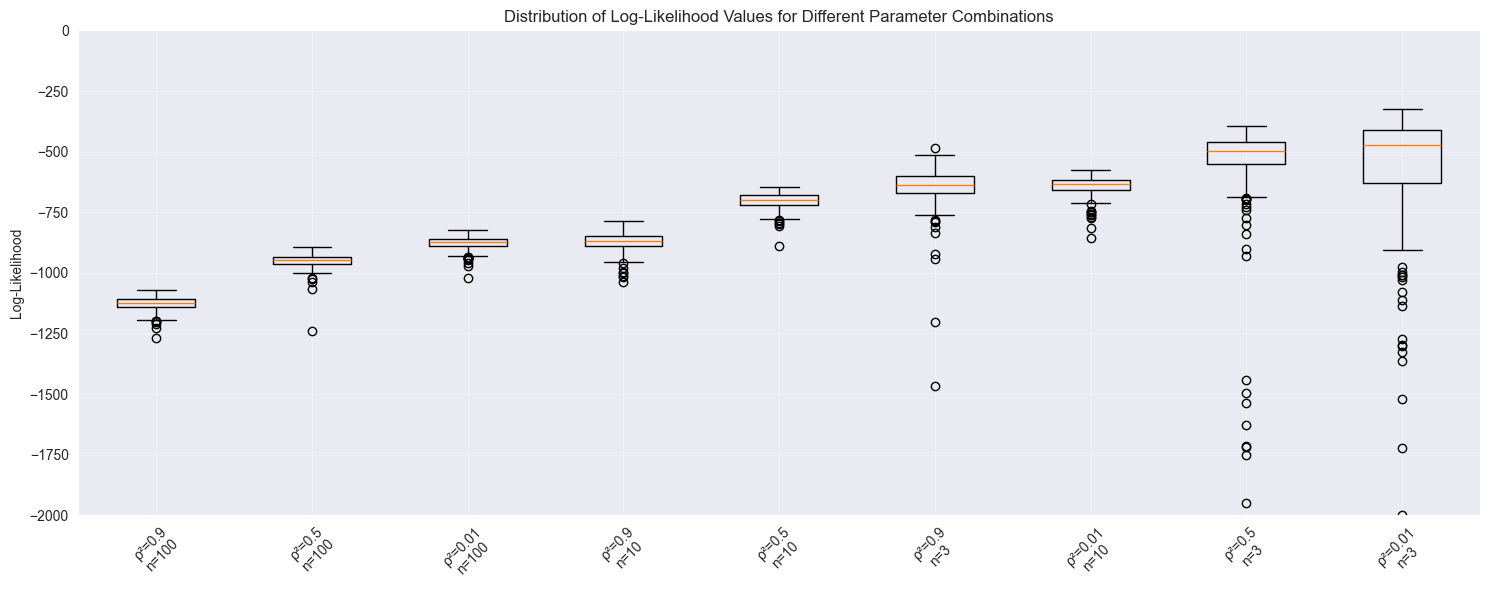

In [88]:
import json
import matplotlib.pyplot as plt
import ast

# Read the JSON file
with open('variation_to_logLt_autovar.json', 'r') as f:
    variation_to_logLt = json.load(f)

# Convert string keys back to tuples and prepare data for plotting
data = []
labels = []
for key in variation_to_logLt.keys():
    params = ast.literal_eval(key)
    data.append(variation_to_logLt[key])
    labels.append(f'ρ²={params[0]}\nn={params[1]}')

# Calculate medians and sort data/labels accordingly
medians = [np.median(d) for d in data]
sorted_indices = np.argsort(medians)
data = [data[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]

# Create the box plot
plt.figure(figsize=(15, 6))
bp = plt.boxplot(data, labels=labels)

# Customize the plot
plt.title('Distribution of Log-Likelihood Values for Different Parameter Combinations')
plt.ylabel('Log-Likelihood')
plt.grid(True, alpha=0.3)
plt.ylim(-2000, 0)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add some padding at the bottom to prevent label cutoff
plt.tight_layout()

plt.show()

In [5]:
import json 
args = [(rho_2,n) for rho_2 in [0.01,0.5,0.9] for n in [3,10,100]]
variation_to_logLt = {str(arg) : [] for arg in args}
N_iter = 250


for arg in tqdm(args,total=len(args),desc='Simulating data'):
    for i in range(N_iter):
        csv_ig = CSV_IG_only_error(rho_2=arg[0],n=arg[1])
        x,y = csv_ig.simulate(100)
        fk_model  = Bootstrap_StructDist(ssm=csv_ig,data=y)
        pf = particles.SMC(fk=fk_model, N=50, resampling='stratified')  # the algorithm
        pf.run()  # actual computation
        variation_to_logLt[str(arg)].append(float(pf.logLt))
        with open('variation_to_logLt_only_error.json', 'w') as f:
            json.dump(variation_to_logLt, f)




Simulating data: 100%|██████████| 9/9 [24:34<00:00, 163.83s/it]


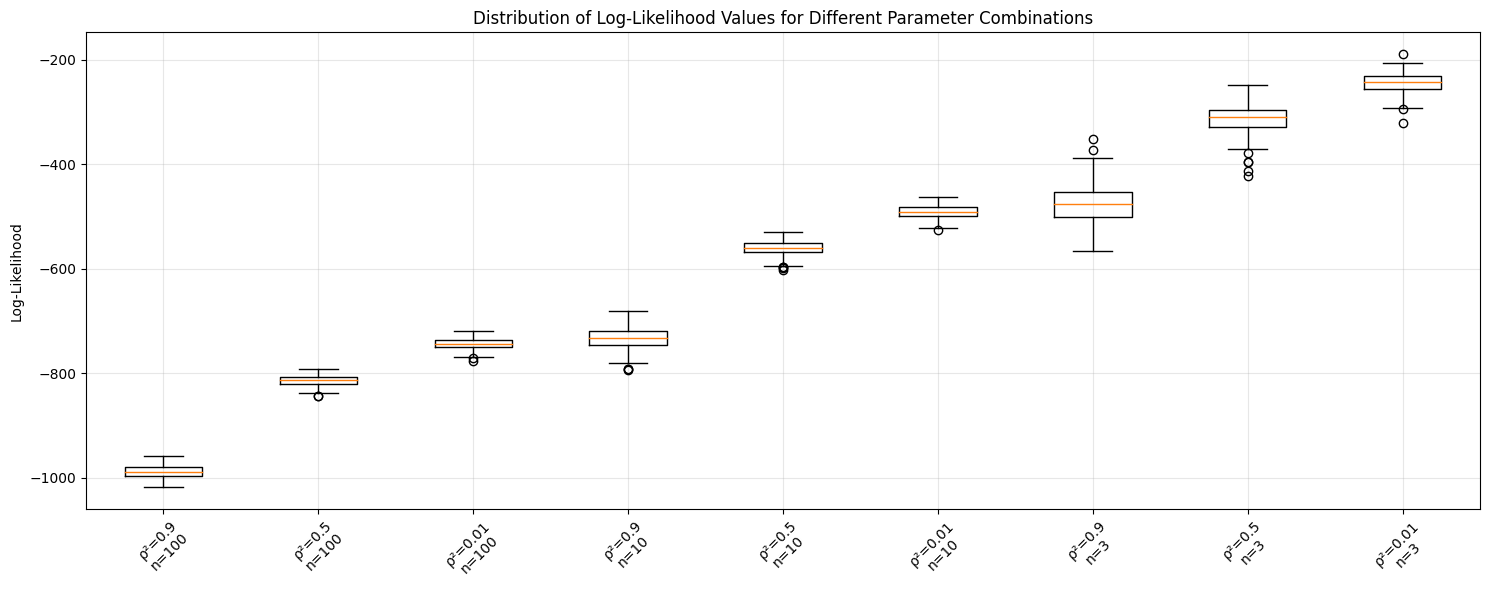

In [6]:
import json
import matplotlib.pyplot as plt
import ast

# Read the JSON file
with open('variation_to_logLt_only_error.json', 'r') as f:
    variation_to_logLt = json.load(f)

# Convert string keys back to tuples and prepare data for plotting
data = []
labels = []
for key in variation_to_logLt.keys():
    params = ast.literal_eval(key)
    data.append(variation_to_logLt[key])
    labels.append(f'ρ²={params[0]}\nn={params[1]}')

# Calculate medians and sort data/labels accordingly
medians = [np.median(d) for d in data]
sorted_indices = np.argsort(medians)
data = [data[i] for i in sorted_indices]
labels = [labels[i] for i in sorted_indices]

# Create the box plot
plt.figure(figsize=(15, 6))
bp = plt.boxplot(data, labels=labels)

# Customize the plot
plt.title('Distribution of Log-Likelihood Values for Different Parameter Combinations')
plt.ylabel('Log-Likelihood')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add some padding at the bottom to prevent label cutoff
plt.tight_layout()

plt.show()


In [11]:
from scipy import stats 

class DiscreteRWHM(mcmc.GenericRWHM):
    """Random walk Hastings-Metropolis for discrete parameters"""
    
    def __init__(self, niter=10, verbose=0, theta0=None, adaptive=False):
        super().__init__(niter=niter, verbose=verbose, theta0=theta0, adaptive=adaptive)
        # Get discrete parameter bounds from prior
        self.bounds = {}
        for name, law in self.prior.laws.items():
            if hasattr(law, 'lo') and hasattr(law, 'hi'):
                self.bounds[name] = (law.lo, law.hi)
    
    def step(self, n):
        # Copy current state
        self.prop.copyto_at(0, self.chain, n-1)
        
        # For each parameter, propose new value
        for name, (lo, hi) in self.bounds.items():
            current = self.chain.theta[name][n-1]
            
            # Propose local or global move
            if np.random.random() < 0.1:  # 10% global moves
                proposed = np.random.randint(lo, hi + 1)
            else:
                # Local move with geometric step size
                step = np.random.geometric(p=0.5) * np.random.choice([-1, 1])
                proposed = current + step
                
                # Reflect at boundaries
                while proposed < lo or proposed > hi:
                    if proposed < lo:
                        proposed = lo + (lo - proposed)
                    if proposed > hi:
                        proposed = hi - (proposed - hi)
            
            self.prop.theta[name][0] = proposed
        
        # Compute posterior at proposal
        self.compute_post()
        
        # For discrete uniform prior, prior ratio is 1.0 (log = 0.0)
        # Only need to consider likelihood ratio
        lp_acc = self.prop.lpost[0] - self.chain.lpost[n-1]
        
        # Accept/reject
        if np.log(stats.uniform.rvs()) < lp_acc:
            self.chain.copyto_at(n, self.prop, 0)
            self.nacc += 1
        else:
            self.chain.copyto_at(n, self.chain, n-1)
class DiscretePMMH(mcmc.PMMH, DiscreteRWHM):
    """PMMH for models with discrete parameters"""
    def __init__(self, ssm_cls=None, prior=None, data=None, Nx=100, niter=10,
                 theta0=None, scale=1., adaptive=False, fk_cls=None):
        super().__init__(ssm_cls=ssm_cls, prior=prior, data=data, Nx=Nx, 
                        niter=niter, theta0=theta0, scale=scale, 
                        adaptive=adaptive, fk_cls=fk_cls)
        # Initialize bounds after prior is set
        self.bounds = {}
        for name, law in self.prior.laws.items():
            if hasattr(law, 'lo') and hasattr(law, 'hi'):
                self.bounds[name] = (law.lo, law.hi)


In [ ]:
csv_ig = CSV_IG_autovar()
x,y = csv_ig.simulate(100)

prior_dict = OrderedDict()
prior_dict['n'] = dists.DiscreteUniform(3,50)

prior_dist = dists.StructDist(prior_dict)

from particles import mcmc  # where the MCMC algorithms (PMMH, Particle Gibbs, etc) live
pmmh = DiscretePMMH(ssm_cls=CSV_IG_autovar, 
                 prior=prior_dist, 
                 data=y, 
                 Nx=50, 
                 niter = 5000,
                 fk_cls = Bootstrap_StructDist)
pmmh.run()


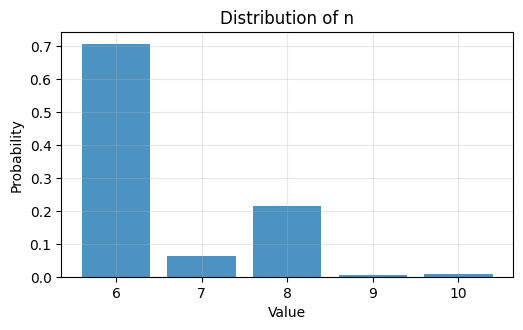

In [15]:
import seaborn as sns
from collections import Counter

burnin = 50  # discard the first 50 iterations
plt.figure(figsize=(10, 6))

for i, param in enumerate(prior_dict.keys()):
    plt.subplot(2, 2, i+1)
    
    # Get values after burnin
    values = pmmh.chain.theta[param][burnin:]
    
    # Count frequency of each discrete value
    value_counts = Counter(values)
    
    # Convert to probabilities
    total = sum(value_counts.values())
    x = sorted(value_counts.keys())
    y = [value_counts[k]/total for k in x]
    
    # Create bar plot
    plt.bar(x, y, alpha=0.8)
    plt.title(f'Distribution of {param}')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
csv_ig = CSV_IG_only_error()
x,y = csv_ig.simulate(100)

prior_dict = OrderedDict()
prior_dict['rho_2'] = dists.Beta(2,2)

prior_dist = dists.StructDist(prior_dict)

from particles import mcmc  # where the MCMC algorithms (PMMH, Particle Gibbs, etc) live
pmmh = mcmc.PMMH(ssm_cls=CSV_IG_autovar, 
                 prior=prior_dist, 
                 data=y, 
                 Nx=50, 
                 niter = 10000,
                 adaptive = False, 
                 fk_cls = Bootstrap_StructDist)
pmmh.run()

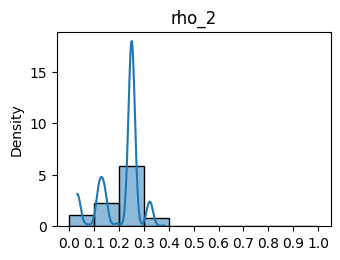

In [8]:
import seaborn as sb
burnin = 50  # discard the 100 first iterations
for i, param in enumerate(prior_dict.keys()):
    plt.subplot(2, 2, i+1)
    # Set bins to create steps of 0.1 from 0 to 1
    sb.histplot(data=pmmh.chain.theta[param][burnin:], 
                stat='density', 
                kde=True,
                bins=np.arange(0, 1.1, 0.1))  # Creates bins [0, 0.1, 0.2, ..., 1.0]
    plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-axis ticks at 0.1 intervals
    plt.title(param)
plt.tight_layout()
plt.show()